# Part 2 - NLP to analyze the main characters 

### Character-Based: 
1. Preliminary Cleaning
2. Build common Modeling Functions
3. Character Analysis 
    * See what words identify the different characters
    * See how this changes between the 1st and last 5 seasons of the show to see how their conversation changed
4. Character Word Clouds
5. Word Usage by Character
6. Making Sense of the data


In [943]:
import numpy as np
import re
import string
import nltk
import sklearn
from nltk.tokenize import MWETokenizer 
from nltk import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
import pandas as pd
import seaborn as sns
pd.set_option('display.max_columns', 50)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from corextopic import corextopic, vis_topic

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

import numpy as np
import scipy.sparse as ss
import matplotlib.pyplot as plt
%matplotlib inline
import collections

In [921]:
df = pd.read_pickle('initial_test_dataframe.pkl')


In [922]:
df

,index,episode,season_number,episode_number,speaker,dialogue,writers,before_speaker,after_speaker,sentence_length,dial_clean
0,3,The One Where Monica Gets a New Roomate (The P...,1,1,Phoebe,"Wait, does he eat chalk?",Marta Kauffman & David Crane,NaN,Phoebe,6,wait does he eat chalk
1,4,The One Where Monica Gets a New Roomate (The P...,1,1,Phoebe,"Just, 'cause, I don't want her to go through\...",Marta Kauffman & David Crane,Phoebe,Monica,16,just cause i don t want her to go through\...
2,5,The One Where Monica Gets a New Roomate (The P...,1,1,Monica,"Okay, everybody relax. This is not even a\nda...",Marta Kauffman & David Crane,Phoebe,Chandler,21,okay everybody relax this is not even a\nda...
3,6,The One Where Monica Gets a New Roomate (The P...,1,1,Chandler,Sounds like a date to me.,Marta Kauffman & David Crane,Monica,Chandler,7,sounds like a date to me
4,7,The One Where Monica Gets a New Roomate (The P...,1,1,Chandler,"Alright, so I'm back in high school, I'm\nsta...",Marta Kauffman & David Crane,Chandler,Chandler,22,alright so i m back in high school i m\nsta...
...,...,...,...,...,...,...,...,...,...,...,...
31449,256,Friends - 10.16 - The One With Rachel's Going ...,10,16,Joey,: A little more.,Andrew Reich & Ted Cohen,Rachel,Phoebe,4,a little more
31450,257,Friends - 10.16 - The One With Rachel's Going ...,10,16,Phoebe,: Okay. (she starts to stuff styrofoam peanuts...,Andrew Reich & Ted Cohen,Joey,Joey,14,okay
31451,258,Friends - 10.16 - The One With Rachel's Going ...,10,16,Joey,": A little more, a little more. (she stuffs so...",Andrew Reich & Ted Cohen,Phoebe,Phoebe,36,a little more a little more a little more...
31452,259,Friends - 10.16 - The One With Rachel's Going ...,10,16,Phoebe,": All right, ready?",Andrew Reich & Ted Cohen,Joey,Joey,4,all right ready


#Done in the cleaning file
df['season_number'] = df['season'].apply(lambda x: int(x[:2]))
df['episode_number'] = df['season'].apply(lambda x: int(x[-2:]))
df = df[df['season_number']!=2]

In [923]:
test_df = df.copy()

==============================================================================================================

## 1. Preprocessing

#### A. Remove the main character names from the dialogue, then append the speaker to the dialogue so we know who said what. 

In [932]:
characters = list(test_df['speaker'].unique())
def remove_name(sentence):
    sentence = re.sub('[%s]' % re.escape(string.punctuation), ' ', sentence)
    words = sentence.split(' ')
    sent_clean = ''
    for word in words:
        if word not in characters:
            sent_clean += word + ' '
    return sent_clean

In [935]:
#This DF will be used for the Topic Modeling
test_df['dial_clean'] = test_df['dial_clean'].apply(lambda x: remove_name(x))


In [934]:
#This DF will be used for the Word Cloud and Character Analysis
test_df_char = test_df.copy()
test_df_char['dial_clean'] = test_df['speaker'] + ' ' + test_df['dial_clean']

#### B. Remove some choice stop words - Hold off on this for now

In [927]:
stop_word = stopwords.words('english')
accepted_words = ['i','me','my','myself','we','our','you','he','him','his','she','her',
 'they','them','what','which','who','whom','but','because','against','when','where','why','how',
 'no','nor','not']
final_stops = [x for x in stop_word if x not in accepted_words]
print(final_stops)

['ours', 'ourselves', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'himself', "she's", 'hers', 'herself', 'it', "it's", 'its', 'itself', 'their', 'theirs', 'themselves', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'if', 'or', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doe

====================================================================================================

## 2. Build the common functions

In [503]:
def vectorize(dataframe, column, vectorizer, stops, min_df = 0, max_df = 1.0, n_grams = (1, 1)):
    if vectorizer == "cv":
        vec = CountVectorizer(stop_words=stops, binary=True, min_df = min_df, max_df = max_df, ngram_range=n_grams)
    elif vectorizer == "tfidf":
        vec = TfidfVectorizer(stop_words=stops, binary=True, min_df = min_df, max_df = max_df, ngram_range=n_grams)

    
    doc_word = vec.fit_transform(dataframe[column])
    feature_names = vec.get_feature_names()
    id2word = dict((v, k) for k, v in vec.vocabulary_.items())
    
    return doc_word, feature_names, id2word

In [504]:
def lsa(doc_word, feature_names, num_topics):
    model = TruncatedSVD(num_topics)
    doc_topic = model.fit_transform(doc_word)
    for ix, topic in enumerate(model.components_):
        print("\nTopic ", ix)
        print(", ".join([feature_names[i] for i in topic.argsort()[:-21:-1]]))

def nmf(doc_word, feature_names, num_topics):
    model = NMF(num_topics)
    doc_topic = model.fit_transform(doc_word)
    for ix, topic in enumerate(model.components_):
        print("\nTopic ", ix)
        print(", ".join([feature_names[i] for i in topic.argsort()[:-21:-1]]))

def lda(doc_word, feature_names, id2word, num_topics):
    corpus = matutils.Sparse2Corpus(doc_word.transpose())
    model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=5, random_state=42)
    topics = model.print_topics()
    for n, topic in topics:
        print("\nTopic ", n)
        print(topic)

===================================================================================================

## 3. Character Based Analysis

#### A. Applying the Corex Model to see if I can accurately separate the characters
- The results from this initial test did really well as expected. Most words can be correctly associated with the characters

In [936]:
#Create a list of all the actors to be used as anchors
chars_anchors = [char.lower() for char in characters]

In [937]:

def corex(doc_word, feature_names, num_topics, anchors, anchor_strength):
    words = list(np.asarray(feature_names))
    model = corextopic.Corex(n_hidden=num_topics, words=words, seed=1, max_iter=200)
    model.fit(doc_word, words=words, anchors=anchors, anchor_strength=anchor_strength)

    topics = model.get_topics(n_words=30)
    print("TC: ", model.tc)
    for n,topic in enumerate(topics):
        topic_words,_ = zip(*topic)
        print('{}: \n'.format(n) + ', '.join(topic_words))

In [77]:
doc_word, feature_names, id2word= vectorize(test_df_char, 'dial_clean', 'cv', final_stops)

In [80]:
corex(doc_word, feature_names, 6, chars_anchors, 20)

TC:  52.5610759637737
0: 
joey, hey, man, dude, audition, ya, doin, agent, um, whoa, actor, tribbiani, porsche, kate, ah, uhh, scene, remoray, right, got, listen, director, estelle, casting, buddy, drake, movie, huh, look, chick, twin, unit, like, auditions, surgery, comin, treeger, pacino, he, character
1: 
phoebe, ooh, frank, cause, ursula, alice, pheebs, okay, mike, sergei, yay, vince, massage, massages, minsk, appelle, philange, jason, wife, client, guitar, buffay, je, but, regina, detector, psychic, negative, good, leslie, clients, maternity, parents, song, triplets, candle, selfless, deed, annie, thick
2: 
monica, yeah, pete, sweetie, we, no, wedding, kinda, guest, chip, barca, competitive, adopt, lounger, turkey, kitchen, gosh, matthews, his, richard, hug, nana, along, neighbors, sauce, potatoes, wendy, sure, mmh, plates, limited, fund, seventh, marinara, calamari, crash, basement, caesar, efficient, thing
3: 
chandler, umm, joe, janice, yes, wait, kathy, gym, babe, wow, cameras

#### B. Split up the seasons by 1st half and 2nd half to see if there are any changes in what identifies the characters: 
    * Joey and Phoebe had no change
    * Monica/Chandler talked a lot more about old relationships in 1st 5 seasons.  They talked much more about togetherness and marriage after
    * Ross talked a lot about relationships.  Then later seemed to pivot more into his career
    * Rachel stayed mostly the same.  Biggest change was that she used to talk a lot about her dad.  That became less later on. 

In [136]:
df_early = test_df_char[test_df_char['season']< '0600'] #Early episodes
df_late = test_df_char[test_df_char['season']>= '0600'] #Later episodes

In [139]:
doc_early, feature_names_early, id2word= vectorize(df_early, 'dial_clean', 'cv', final_stops)
doc_late, feature_names_late, id2word= vectorize(df_late, 'dial_clean', 'cv', final_stops)

/opt/miniconda3/envs/metis/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['she', 'you'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [146]:
corex(doc_early, feature_names_early, 6, chars_anchors, 20)

TC:  52.673579610867606
0: 
joey, hey, man, kate, okay, actor, whoa, dude, agent, doin, ya, listen, got, tribbiani, uhh, chick, right, twin, unit, chinese, casting, bijan, lauren, heston, audition, estelle, ok, underwear, he, noodle
1: 
phoebe, ooh, oh, frank, um, cause, ah, pheebs, sergei, alice, really, but, vince, know, jason, like, oooh, mom, whore, minsk, massage, everyone, ursula, puppy, birth, selfless, song, house, deed, writes
2: 
monica, yeah, well, pete, no, richard, chip, kinda, gosh, carpet, wendy, doug, salmon, competitive, we, potatoes, matthews, involve, his, cute, sister, father, marinara, classes, photo, altar, seventh, senior, crash, name
3: 
chandler, yes, janice, umm, joe, kathy, wait, gym, angela, mary, chasing, crystal, sweetie, duck, wedding, looks, you, seats, trppd, condoms, racquet, vstbl, surprisingly, brian, dick, breaks, moon, tailor, wth, crack
4: 
ross, uh, carol, emily, marcel, susan, ben, rach, correct, wife, amanda, boxes, lesbian, gimme, supposed, wh

In [147]:
corex(doc_late, feature_names_late, 6, chars_anchors, 20)

TC:  52.89265467794159
0: 
joey, hey, audition, dude, porsche, rach, ya, we, scene, hi, buddy, remoray, stomach, tribbiani, pizza, huh, terry, surgery, movie, doin, man, me, guy, agent, eats, director, thursday, take, dramatic, auditions
1: 
phoebe, ursula, mike, frank, appelle, alice, yay, cause, whoa, je, detector, triplets, mean, massage, jeweler, tiara, psychic, russia, massages, leslie, philange, eric, missing, anniversary, bay, claude, em, what, denise, cab
2: 
monica, wedding, sweetie, guest, amanda, pink, kitchen, dad, adopt, barca, fold, lounger, days, went, invited, neighbors, date, look, cut, parents, cookies, eat, caesar, dresses, sink, nana, calamari, lewis, limited, stays
3: 
chandler, umm, joe, yeah, tulsa, sperm, zack, ok, game, money, wife, cameras, ring, our, ho, richard, merry, owen, universe, babe, door, ugh, closet, spend, ohh, christmas, wait, girls, might, secrets
4: 
ross, uh, honey, ben, paleontology, hanukkah, sister, mona, holiday, section, professor, work, s

=============================================================================================

## 4. Word Clouds

In [24]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

In [938]:
def plot_cloud(dataframe, character, stops, wordcloud, max_words=50):
    #Create the DF by Character and then create the long text string of all dialogue from the character
    df_word = dataframe.iloc[:, :20]
    df_char = df_word[df_word['speaker']==character]['dial_clean'].str.cat(sep=' ', na_rep='?')
    
    #Create Extra Stopwords
    extra_stops = ['will', 'got', 'said', 'two', 'one', 'his', 'let', 'way', 'got', 
                   'back', 'year', 'said', 'still', 'come', 'say', 'not', 'yeah', 'see', 'but', 'know']
    final_stops.extend(extra_stops)
    
    #Create the wordcloud
    wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', 
                      collocations=False, stopwords = stops, max_words=max_words,
                          min_word_length=1).generate(df_char)
    
    #Build the plot dimensions
    plt.figure(figsize=(7, 7))
    plt.imshow(wordcloud) 
    plt.axis("off");


#### A. 1st pass with Word Cloud
- Results were not very conclusive so will add more stop words on 2nd pass

In [939]:
stop_word = stopwords.words('english')

In [940]:
accepted_words = ['i','me','my','myself','we','our','you','he','him','his','she','her',
 'they','them','what','which','who','whom','but','because','against','when','where','why','how',
 'no','nor','not']
final_stops = [x for x in stop_word if x not in accepted_words]

In [941]:
#1st Pass Attempt
plot_cloud(test_df, 'Chandler', final_stops, wordcloud)
plot_cloud(test_df, 'Ross', final_stops, wordcloud)
plot_cloud(test_df, 'Joey', final_stops, wordcloud)
plot_cloud(test_df, 'Rachel', final_stops, wordcloud)
plot_cloud(test_df, 'Monica', final_stops, wordcloud)
plot_cloud(test_df, 'Phoebe', final_stops, wordcloud)

NameError: name 'wordcloud' is not defined

#### B. Word Cloud - 2nd pass
- Results are still pretty bad with the extra stop words.  
- Instead of looking at distinctive words, maybe it's actually worth checking out these common words and see how the different characters use them. 

In [245]:
extra_stops = ['will', 'got', 'said', 'two', 'one', 'his', 'let', 'way', 'got', 
               'back', 'year', 'said', 'still', 'come', 'say', 'not', 'yeah', 'see', 'know', 
               'ye', 'll', 've', 're', 'didn','guy', 'man', 'got', 'go', 'one', 'want', 'back', 'wait', 'something']
final_stops.extend(extra_stops)

/opt/miniconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/miniconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


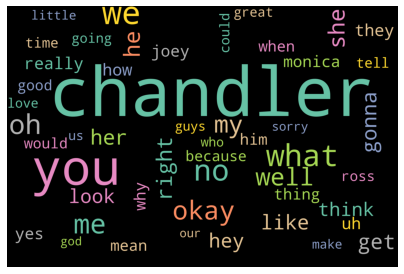

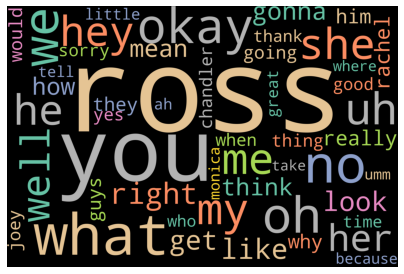

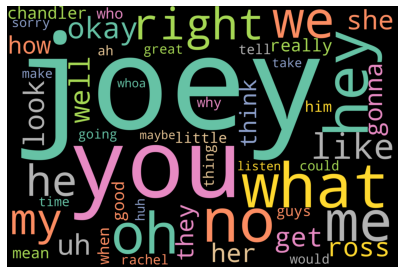

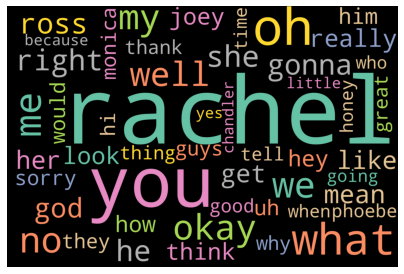

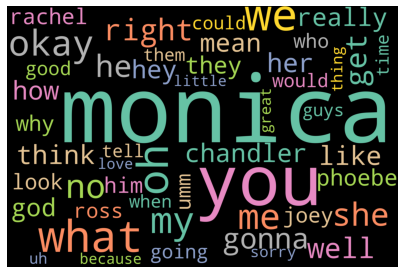

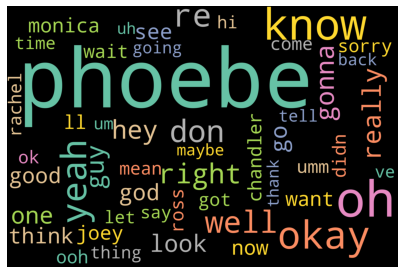

In [248]:
#3rd Pass Attempt
plot_cloud(test_df, 'Chandler', final_stops, wordcloud)
plot_cloud(test_df, 'Ross', final_stops, wordcloud)
plot_cloud(test_df, 'Joey', final_stops, wordcloud)
plot_cloud(test_df, 'Rachel', final_stops, wordcloud)
plot_cloud(test_df, 'Monica', final_stops, wordcloud)
plot_cloud(test_df, 'Phoebe', final_stops3, wordcloud)

================================================================================================

## 5. Word Usage by Character

#### A. Build the Dataframe which consists characters as columns and the count of the words each characters use

In [942]:
import collections

def char_word(df, character, stops=None):
    ''' This function takes the datafarme and outputs a word counter dictionary of every word used
    '''
    df_word = test_df.iloc[:, :20]
    df_char = df_word[df_word['speaker']==character]['dial_clean'].str.cat(sep=' ', na_rep='?')

    stop_words = ['asdfafd']#final_stops

    # Instantiate a dictionary, and for every word in the file, 
    # Add to the dictionary if it doesn't exist. If it does, increase the count.
    wordcount = {}
    # To eliminate duplicates, remember to split by punctuation, and use case demiliters.
    for word in df_char.split():
        if word not in stop_words:
            if word not in wordcount:
                wordcount[word] = 1
            else:
                wordcount[word] += 1

    word_counter = collections.Counter(wordcount)
    return dict(word_counter)

In [593]:
from functools import reduce
dfs = []
df_new = pd.DataFrame()
for char in characters:
    dic = char_word(test_df, char)
    df = pd.Series(dic).to_frame(char).reset_index().sort_values(by=char, ascending = False)
    dfs.append(df)
    #df_new.merge(df, on='index', how='outer') 
    #print(df.iloc[:, :10])
# df_comb = pd.concat(dfs)


In [708]:
df_comb = reduce(lambda x, y: pd.merge(x, y, on = 'index'), dfs)

In [709]:
df_comb.head(100)

,index,Joey,Phoebe,Monica,Chandler,Ross,Rachel
0,i,2352,1916,2174,2458,2835,2966
1,you,1961,1936,2205,1988,2231,2370
2,the,1335,1077,1270,1449,1439,1206
3,to,1109,887,1083,1107,1294,1199
4,a,1096,889,948,1043,1086,1013
5,and,1016,921,868,972,998,1047
6,it,929,791,945,908,970,969
7,that,754,688,771,890,786,948
8,no,603,497,361,568,630,543
9,hey,577,215,205,244,388,204


#### B. Analyze Filler words (AKA Discourse words) - These are words that don't add any value to a sentence

In [710]:
#These are filler words
filler_words = ['uh', 'uhh', 'um', 'like', 'oh', 'ah', "y'know", 'right', 'so', 'anyway']

In [944]:
#Take a look at the count of total words that each character used
df_comb.iloc[:, 1:].sum()

Joey        49158
Phoebe      43080
Monica      47045
Chandler    49588
Ross        53928
Rachel      55087
dtype: int64

In [739]:
#What percentage of words are "filler words"
char_filler = df_comb[df_comb['index'].isin(filler_words)].iloc[:, 1:].sum()*100/ df_comb.iloc[:, 1:].sum()
char_words_df = pd.DataFrame(char_filler)

In [740]:
char_words_df['Percentage Discourse Words'] = char_words_df[0].round(2)
char_words_df.drop(columns=[0], axis = 1, inplace=True)
char_words_df

#### C.  Just for filler words, I wanted to see analyze this a bit further and see how usage changed over time.  

In [727]:
def count_filler(dialogue):
    c = 0
    for i in dialogue.split(' '): 
        if i in filler_words:
            c+= 1
    return c

In [728]:
#Takes each episode and adds a count of how many filler words each character uses
episode_df['filler_count'] = episode_df['dial_clean'].apply(lambda x: count_filler(x)/(len(x.split(' '))-3))
episode_df

,season_number,episode_number,speaker,dial_clean,filler_count
0,1,1,Chandler,sounds like a date to me alright so i m b...,0.016032
1,1,1,Joey,c mon you re going out with the guy there s...,0.016975
2,1,1,Monica,okay everybody relax this is not even a\nda...,0.022581
3,1,1,Phoebe,wait does he eat chalk just cause i do...,0.023136
4,1,1,Rachel,oh god hi thank god i just went to\nyour bu...,0.021140
...,...,...,...,...,...
842,10,16,Joey,all right all right all right let s play ...,0.031513
843,10,16,Monica,hey rach you re leaving tomorrow shouldn ...,0.027112
844,10,16,Phoebe,hey oh he has a gig i kinda like being...,0.021654
845,10,16,Rachel,ok can t believe i m risking this again b...,0.031291


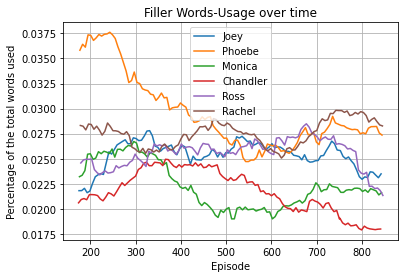

In [729]:
for char in characters:
    #plt.figure(figsize=(10, 5))
    episode_df[episode_df['speaker']==char]['filler_count'].rolling(window=30).mean().plot(label=char)
    plt.legend()
    plt.title('Filler Words-Usage over time')
    plt.ylabel('Percentage of the total words used')
    plt.xlabel('Episode')
    plt.grid()


#### D. Look at the Me Words - This may indicate someone who talks about themselves a lot

In [742]:
me_words = ['i', 'me', 'my', 'mine']

In [743]:
char_words_df['Percentage I words'] = df_comb[df_comb['index'].isin(me_words)].iloc[:, 1:].sum()*100/df_comb.iloc[:, 1:].sum()
#char_me.reset_index()

#### E. Look at the You Words - This may indicate someone who is bossy but not sure yet

In [744]:
you_words = ['you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves']

char_words_df['Percentage you words']  = df_comb[df_comb['index'].isin(you_words)].iloc[:, 1:].sum()*100/df_comb.iloc[:, 1:].sum()

In [745]:
char_words_df['Percentage I words'] = char_words_df['Percentage I words'].round(2)
char_words_df['Percentage you words'] = char_words_df['Percentage you words'].round(2)
char_words_df.sort_index()

,Percentage Discourse Words,Percentage I words,Percentage you words
Chandler,3.45,6.68,4.47
Joey,4.12,6.68,4.47
Monica,3.63,6.45,5.21
Phoebe,4.79,6.28,5.07
Rachel,4.59,7.46,4.81
Ross,4.13,6.90,4.62


In [746]:
char_words_df["Total Percentage"] = char_words_df.sum(axis=1)
char_words_df

,Percentage Discourse Words,Percentage I words,Percentage you words,Total Percentage
Joey,4.12,6.68,4.47,15.27
Phoebe,4.79,6.28,5.07,16.14
Monica,3.63,6.45,5.21,15.29
Chandler,3.45,6.68,4.47,14.60
Ross,4.13,6.90,4.62,15.65
Rachel,4.59,7.46,4.81,16.86


In [747]:
char_words_df.iloc[:, :].astype(str) + '%'

,Percentage Discourse Words,Percentage I words,Percentage you words,Total Percentage
Joey,4.12%,6.68%,4.47%,15.27%
Phoebe,4.79%,6.28%,5.07%,16.14%
Monica,3.63%,6.45%,5.21%,15.29%
Chandler,3.45%,6.68%,4.47%,14.599999999999998%
Ross,4.13%,6.9%,4.62%,15.650000000000002%
Rachel,4.59%,7.46%,4.81%,16.86%
